# DaCapo Tail Latency Curve

## 1. Copy latency hdr files to this machine

```console
$ rsync -azR --no-i-r -h --info=progress2 squirrel.moma:/home/wenyuz/./MMTk-Dev/evaluation/results/log/lxr-latency-bear-2023-12-21-Thu-114935 /home/wenyuz
```

## 2. Plot curves

In [1]:
from hdrh.histogram import HdrHistogram
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from enum import Enum
import matplotlib as mpl
from pathlib import Path

In [2]:
class LatencyType(Enum):
    METERED = "metered"
    SIMPLE = "simple"


LATENCY_TYPE = LatencyType.METERED

RUNIDS = [
    "[lxr-prod]latency-boar-2025-03-20-Thu-014727",
    # 'lxr-latency-bear-2023-12-21-Thu-114935',
]

SAVE_FILE = "pdf"
# SAVE_FILE = 'jpg'
# SAVE_FILE = None

MAX_INVOCATIONS = 40
MIN_LATENCY_USEC = 1
MAX_LATENCY_USEC = 1000 * 1000  # 1 sec
LATENCY_SIGNIFICANT_DIGITS = 5

LABEL_FONT_SIZE = 50
LEGEND_FONT_SIZE = 50
TICK_FONT_SIZE = 50

GCS = ["jdk-lxr.lxr", "jdk-lxr-jul2023.lxr", "jdk-lxr.g1", "jdk-lxr.shenandoah"]
GC_NAMES = ["$LXR_O$", "$LXR_F$", "$G1$", "$Shen.$", "$ZGC$"]
COLORS = ["green", "green", "blue", "chocolate", "red"]
LINESTYLES = {
    "jdk-lxr.lxr": "",
    "jdk-lxr-jul2023.lxr": "--",
    "jdk-lxr.g1": "",
    "jdk-lxr.shenandoah": "",
    "jdk-lxr.zgc": "",
}

SAVE_PDF = True

In [3]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Linux Biolinum"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42


def load_latency_data(bench: str, latency_type: LatencyType, folder: Path):
    folders = list(folder.glob(f"{bench}.*"))
    print(f"[{bench}] Loading histograms from {len(folders)} folders ...")
    histograms: dict[str, list[HdrHistogram]] = {}
    for i, child in enumerate(folders, start=1):
        if not child.is_dir():
            continue
        parts = child.name.split(".")
        gc = parts[3] + "." + parts[4]
        # if gc == "Z" and parts[6] == "zgc_gen": gc = "GenZ"
        bench = parts[0]
        for hdr in child.glob(f"*-{latency_type.value}-4.hdr"):
            parts = hdr.stem.split("-")
            with hdr.open("r") as fd:
                hist_raw = fd.read().split(",")[3]
                hist = HdrHistogram.decode(hist_raw)
                if gc not in histograms:
                    histograms[gc] = []
                histograms[gc].append(hist)
    return histograms


def load_data_and_plot(bench: str, save: bool = False, latency_type: LatencyType = LATENCY_TYPE, legend: str | bool = True, max_percentile="99.9999"):
    print(f"[{bench}] Loading ...")
    # Load data
    histograms = {}
    for runid in RUNIDS:
        hists = load_latency_data(bench, latency_type, Path(f"/home/wenyuz/MMTk-Dev/evaluation/results/log/{runid}"))
        for gc, h in hists.items():
            if gc not in histograms:
                histograms[gc] = []
            histograms[gc].extend(h)
    # Process data
    histograms_len = sum([len(x) for x in histograms.values()])
    print(f"[{bench}] Processing {histograms_len} histograms ...")
    percentile_list = []
    for gc, hists in histograms.items():
        for j, histogram in enumerate(hists):
            for i in histogram.get_percentile_iterator(5):
                percentile_list.append({"GC": gc, "inv": j, "value": i.value_iterated_to, "percentile": i.percentile_level_iterated_to / 100})
    percentile_list.sort(key=lambda x: GCS.index(x["GC"]))
    max_gcs = len(set(x["GC"] for x in percentile_list))
    percentile_df = pd.DataFrame(percentile_list)
    percentile_df["reciprocal"] = 1 / (1 - percentile_df["percentile"])
    # Plot curves
    print(f"[{bench}] Plotting ...")
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    # fig.suptitle(f'{bench} {latency_type} latency')
    sns.color_palette()
    ax = sns.lineplot(data=percentile_df, x="reciprocal", y="value", hue="GC", palette=COLORS[:max_gcs])
    ax.lines[1].set_linestyle("--")
    # ax.lines[1].set_linestyle(":")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Percentile", fontsize=LABEL_FONT_SIZE, labelpad=12)
    ax.set_ylabel("Latency (msec)", fontsize=LABEL_FONT_SIZE, labelpad=12)
    labels = ["0", "90", "99", "99.9", "99.99", "99.999", "99.9999"]
    ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000][: labels.index(max_percentile) + 1])
    ax.set_xticklabels([l if l != labels[-1] else "" for l in labels[: labels.index(max_percentile) + 1]], fontsize=TICK_FONT_SIZE, rotation=0)
    plt.yticks(fontsize=TICK_FONT_SIZE)

    def formaty(x, _):
        x = x / 1000.0
        if int(x) == float(x):
            return f"{int(x)}"
        s = f"{x}"
        # if s.startswith("0.0"):
        #     return "0"
        return s

    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formaty))  # type: ignore
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2, 3, 4, 1, 0]
    if legend == False:
        plt.legend([], [], frameon=False)
    elif legend == True:
        plt.legend([handles[i] for i in order if i < len(handles)], [GC_NAMES[GCS.index(labels[i])] for i in order if i < len(labels)], fontsize=LEGEND_FONT_SIZE)
    else:
        leg = plt.legend([handles[i] for i in order if i < len(handles)], [GC_NAMES[GCS.index(labels[i])] for i in order if i < len(labels)], fontsize=LEGEND_FONT_SIZE, loc=legend, labelspacing=0)
        # leg.get_lines()[2].set_linestyle(":")
    plt.tight_layout()
    # Dump figure to file
    if save or SAVE_PDF:
        print(f"[{bench}] Save to latency-{bench}.{SAVE_FILE}")
        plt.savefig(f"/home/wenyuz/MMTk-Dev/latency-{bench}.{SAVE_FILE}", bbox_inches="tight")

# lusearch

[lusearch] Loading ...
[lusearch] Loading histograms from 65 folders ...
[lusearch] Processing 60 histograms ...
[lusearch] Plotting ...
[lusearch] Save to latency-lusearch.pdf


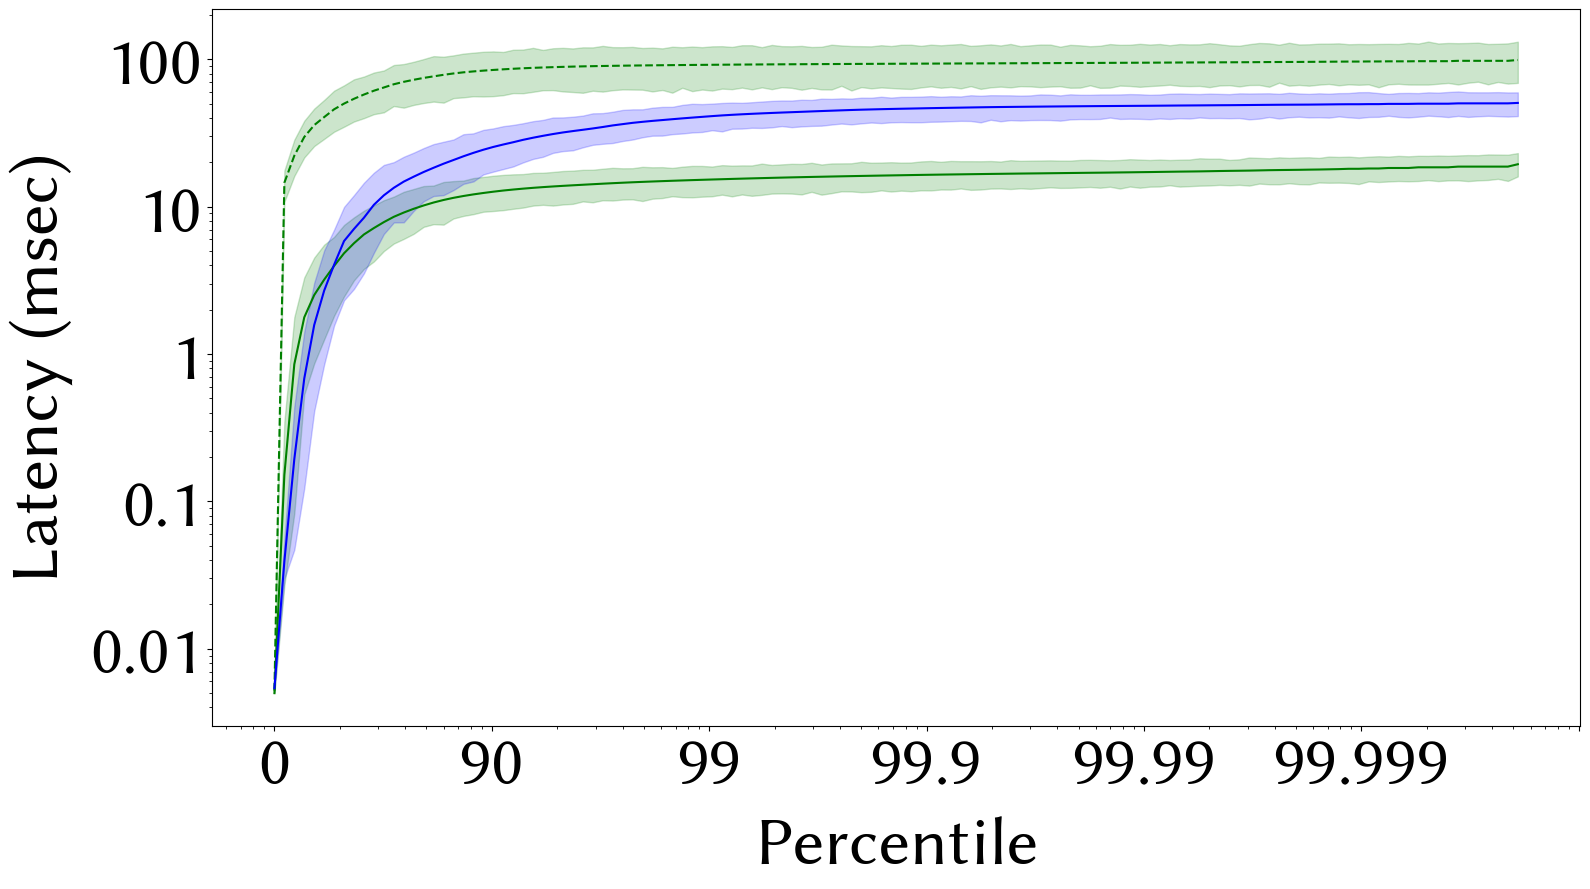

In [4]:
load_data_and_plot(bench="lusearch", legend=False)

# cassandra

[cassandra] Loading ...
[cassandra] Loading histograms from 84 folders ...
[cassandra] Processing 79 histograms ...
[cassandra] Plotting ...
[cassandra] Save to latency-cassandra.pdf


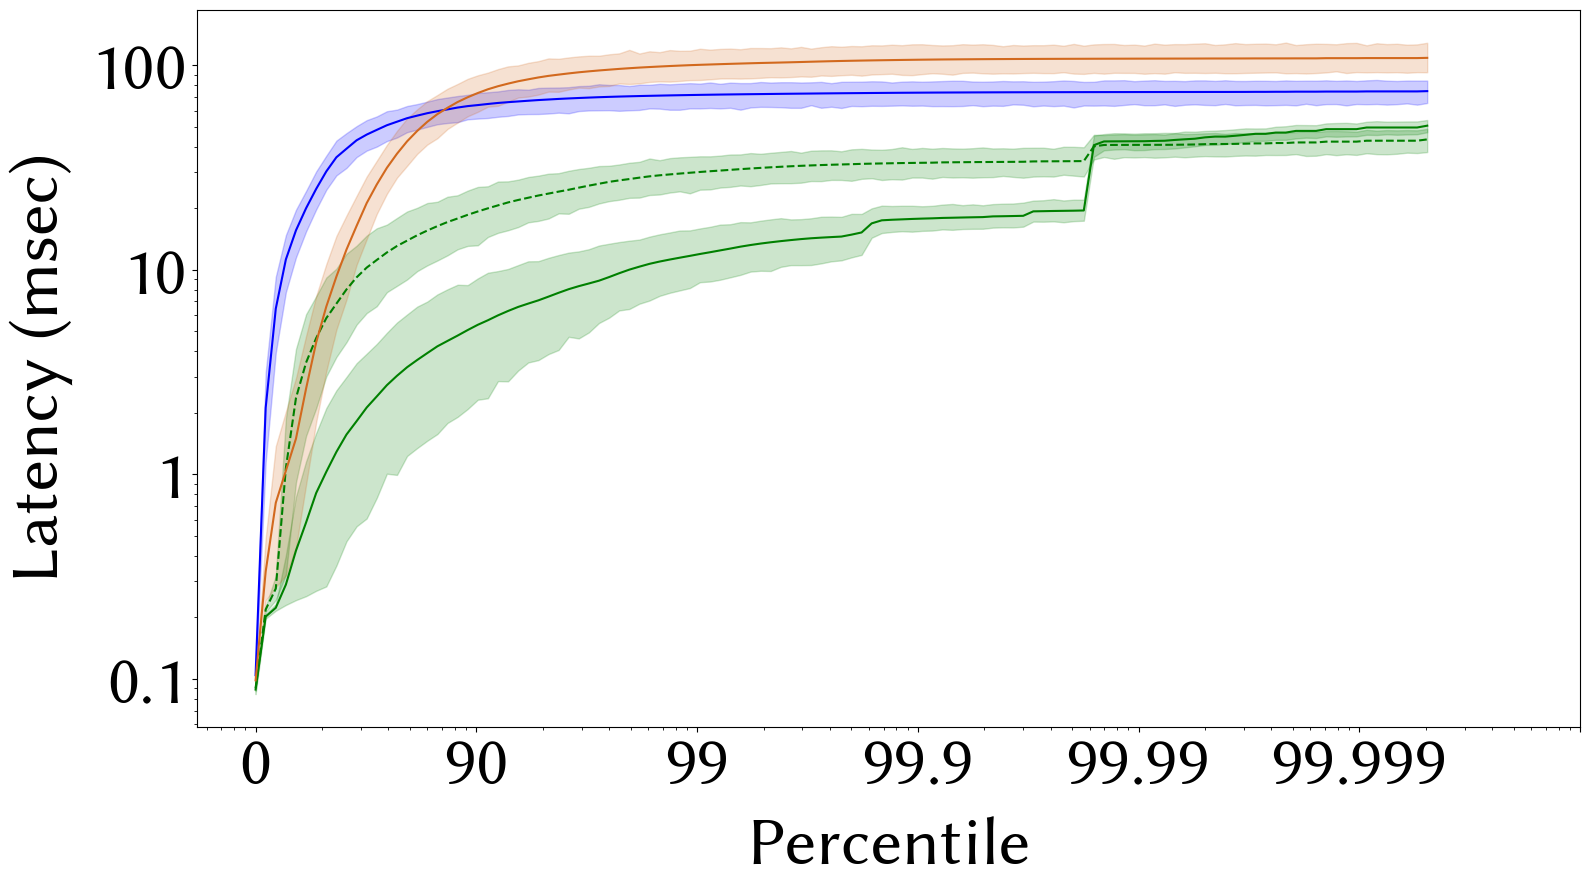

In [5]:
load_data_and_plot(bench="cassandra", legend=False)

# h2

[h2] Loading ...
[h2] Loading histograms from 85 folders ...
[h2] Processing 80 histograms ...
[h2] Plotting ...
[h2] Save to latency-h2.pdf


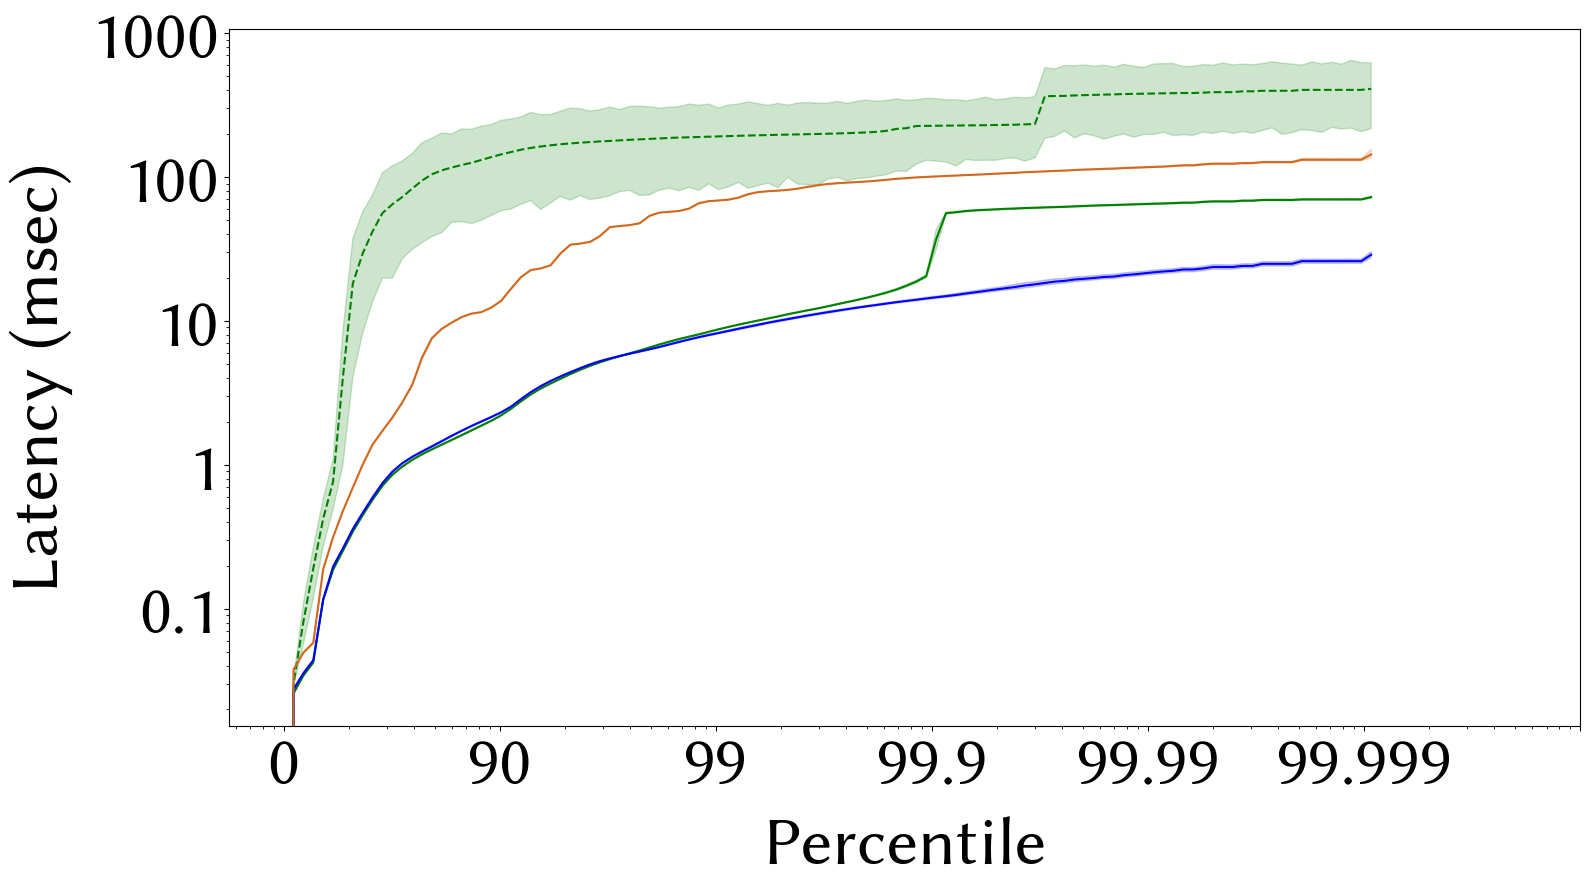

In [6]:
load_data_and_plot(bench="h2", legend=False)

# spring

[spring] Loading ...
[spring] Loading histograms from 84 folders ...
[spring] Processing 79 histograms ...
[spring] Plotting ...
[spring] Save to latency-spring.pdf


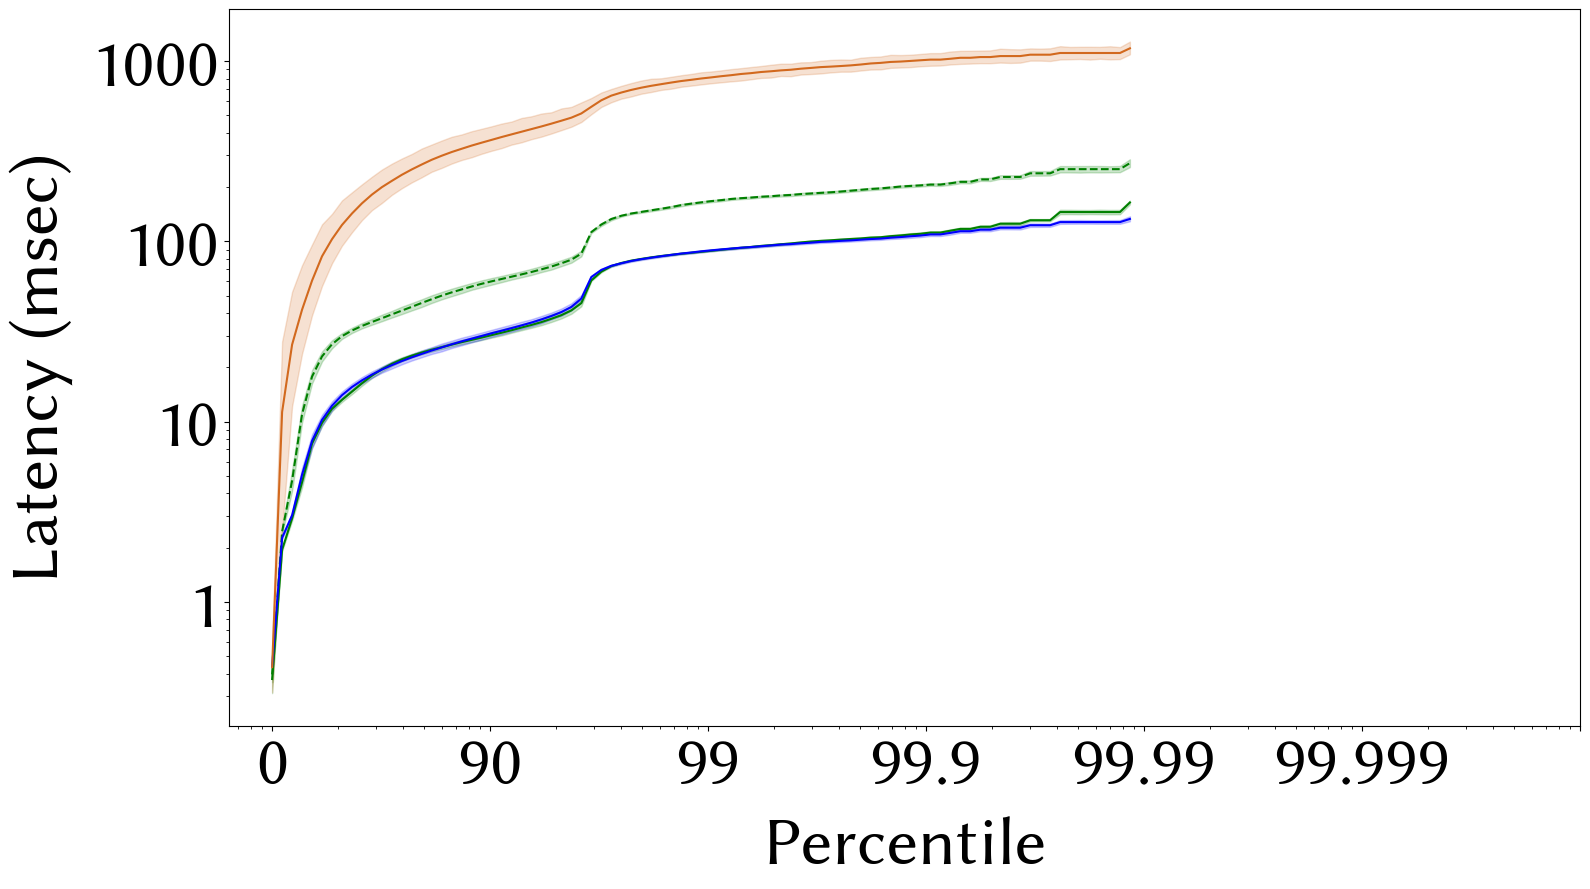

In [7]:
load_data_and_plot(bench="spring", legend=False)

# tradesoap

[tradesoap] Loading ...
[tradesoap] Loading histograms from 85 folders ...
[tradesoap] Processing 80 histograms ...
[tradesoap] Plotting ...
[tradesoap] Save to latency-tradesoap.pdf


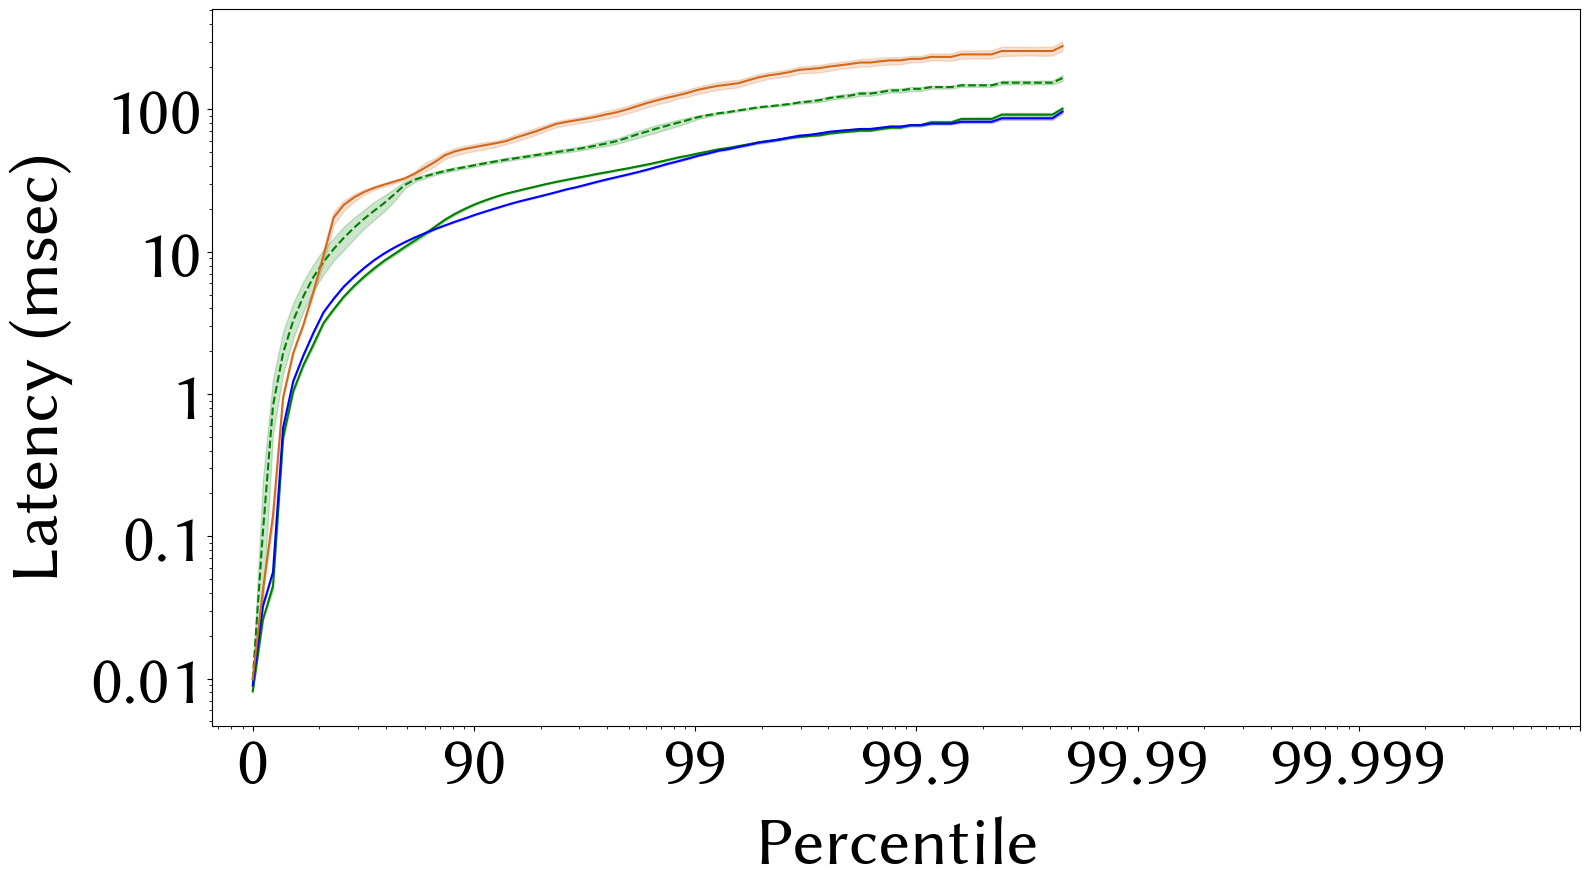

In [8]:
load_data_and_plot(bench="tradesoap", legend=False)

# tradebeans

[tradebeans] Loading ...
[tradebeans] Loading histograms from 85 folders ...
[tradebeans] Processing 80 histograms ...
[tradebeans] Plotting ...
[tradebeans] Save to latency-tradebeans.pdf


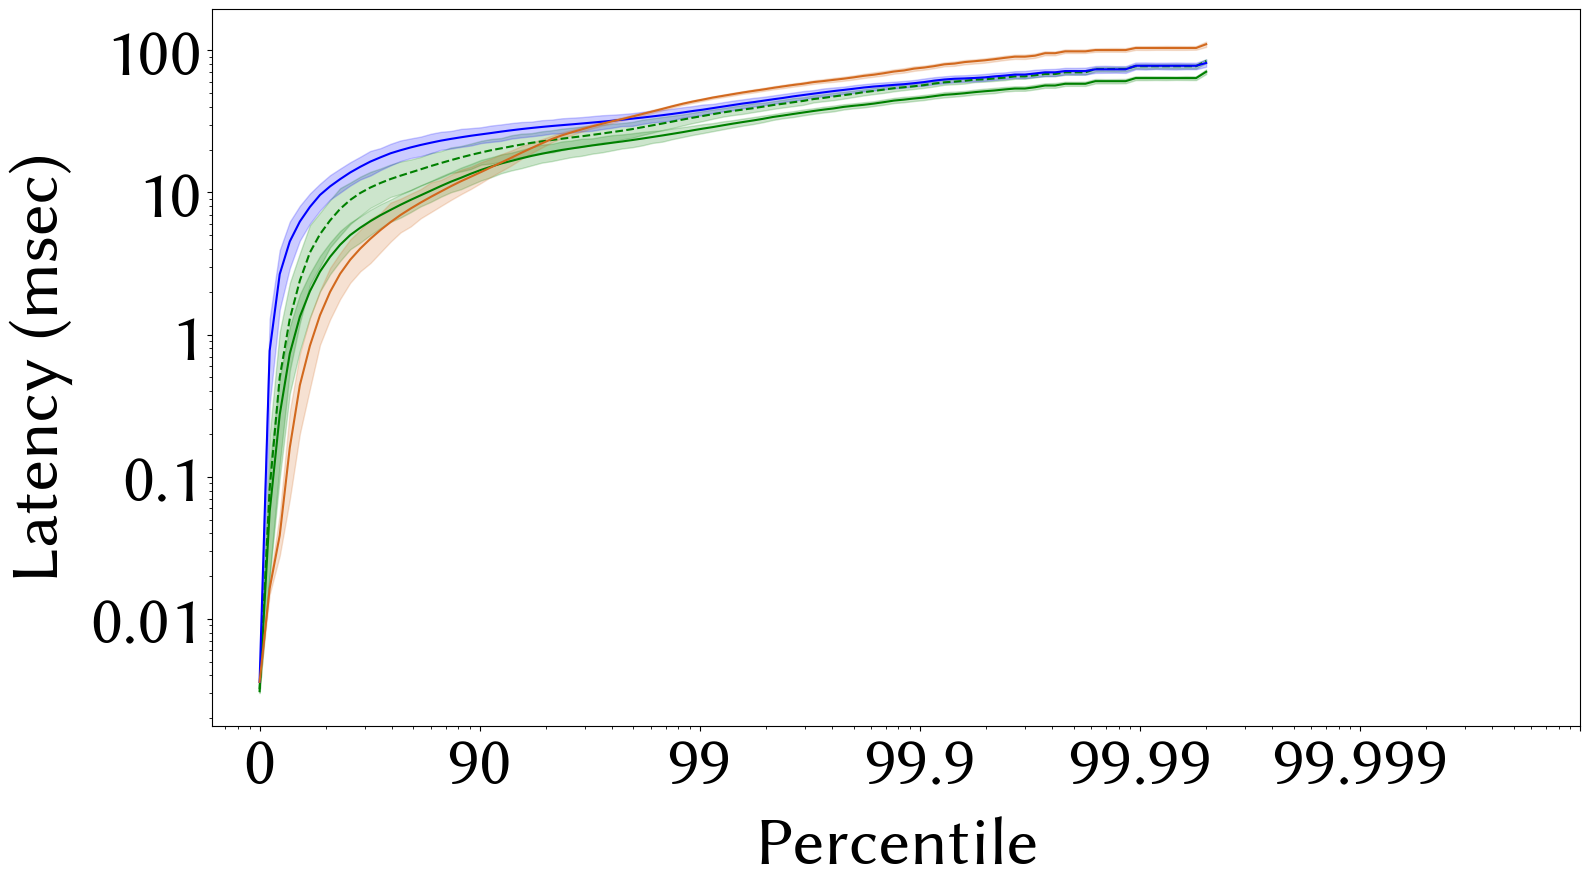

In [9]:
load_data_and_plot(bench="tradebeans", legend=False)

# tomcat

[tomcat] Loading ...
[tomcat] Loading histograms from 84 folders ...
[tomcat] Processing 79 histograms ...
[tomcat] Plotting ...
[tomcat] Save to latency-tomcat.pdf


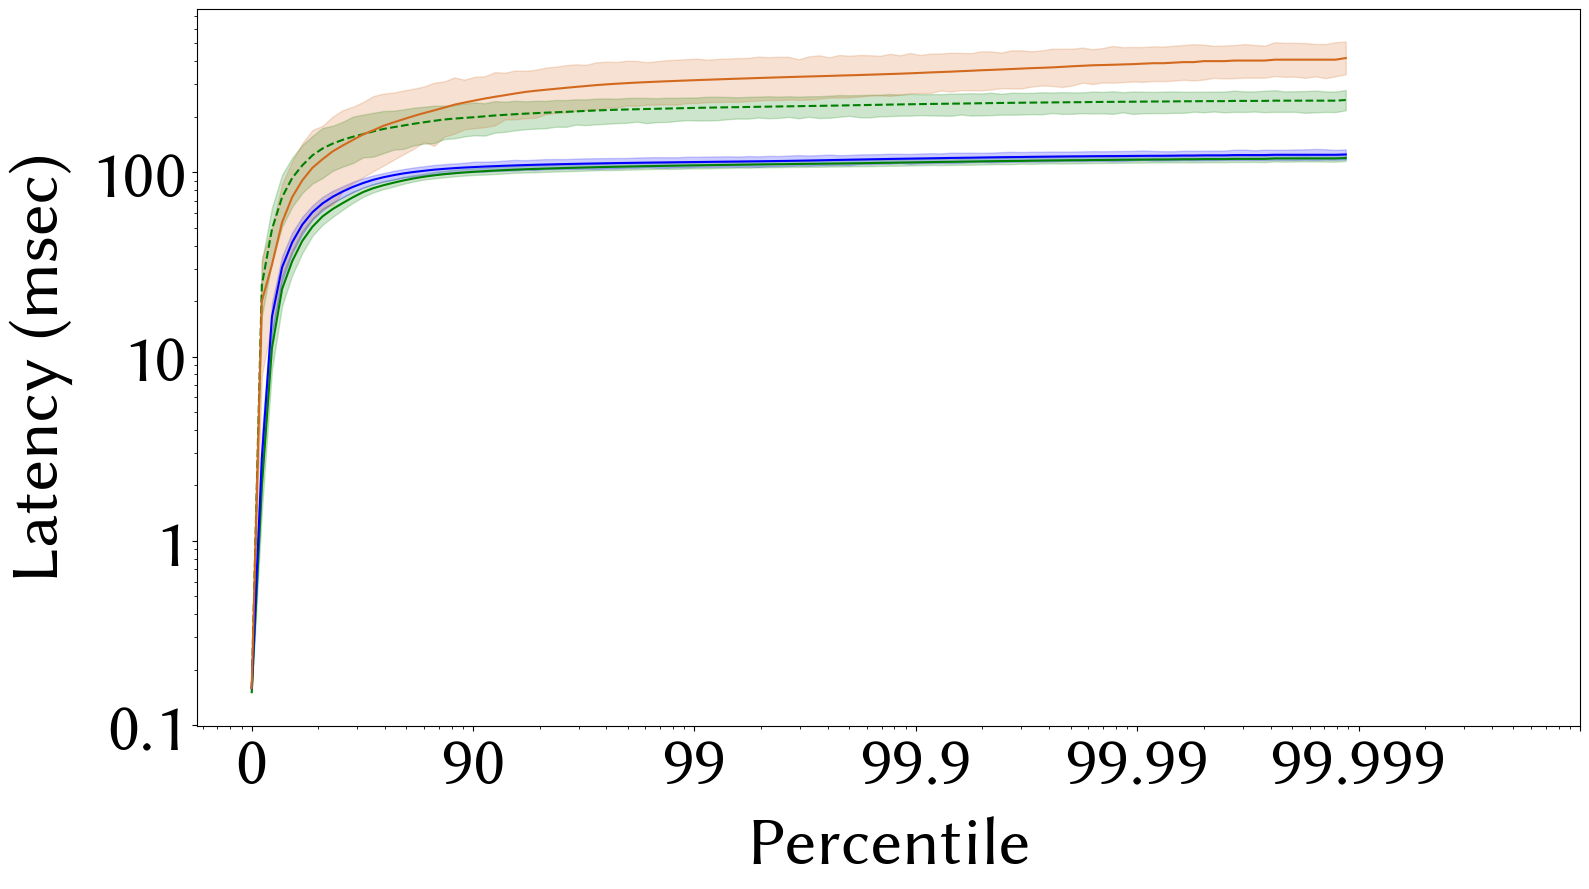

In [10]:
load_data_and_plot(bench="tomcat", legend=False)

# kafka

[kafka] Loading ...
[kafka] Loading histograms from 85 folders ...
[kafka] Processing 80 histograms ...
[kafka] Plotting ...


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


[kafka] Save to latency-kafka.pdf


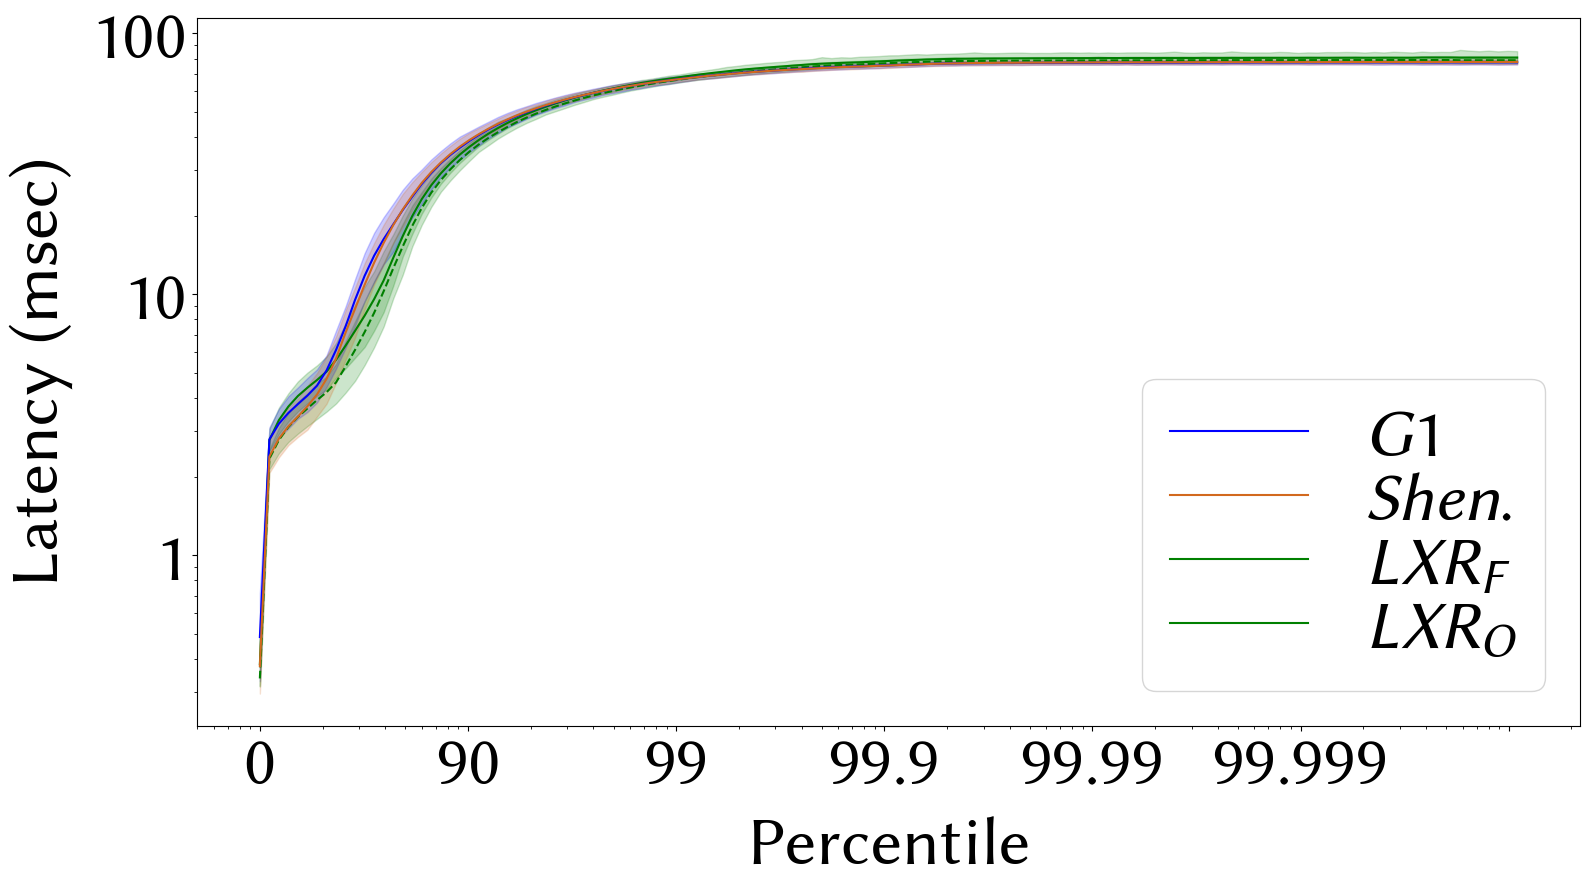

In [11]:
load_data_and_plot(bench="kafka", legend="lower right")